In [154]:
from abc import ABC, abstractmethod
import numpy as np
import logging
import matplotlib.pyplot as plt
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Testing logger")
class AbstractClassExample(ABC):
 
    def __init__(self, value):
        self.value = value
        super().__init__()
    
    @abstractmethod
    def do_something(self):
        pass

INFO:root:Testing logger


# Ode_system classes creation

## Abstract class creation

In [475]:
class Ode1Solver(ABC):
    def __init__(self,N,time_interval,function):
        self.y=np.array([])
        self.N=N
        self.t0=time_interval[0]
        self.t1=time_interval[1]
        self.h=(self.t1-self.t0)/N
        self.f=function
        self._y_inizialization()
        self.t=np.linspace(self.t0,self.t1,self.N+1)
        super().__init__()
    def _y_inizialization(self):
        self.y=np.zeros([1,self.N+1])[0]
    @abstractmethod
    def y_calculation(self):
        pass
        
        
        
        

## Solvers

In [948]:
def explicit_euler_state(y,u,x,h,y1,function):
    logging.info("time step{}".format(h))
    logging.info("initial condition {}".format(y1))
    f=function
    y[0]=y1
    logging.info("Setting initial condition  {}".format(y[0]))
    for i in range(len(x)-1):
        y[i+1]=y[i]+h*f(y[i],u[i],x[i])
        #y[i+1]=y[i]+h*x[i]**2
        
    return y


def explicit_euler_adjoint(y,y_state,u,x,h,y1,function,partial_g):
    logging.info("time step{}".format(h))
    logging.info("initial condition {}".format(y1))
    y[-1]=y1
    y_state=np.flip(y_state)

    f=function
    y[0]=y1
    logging.info("Setting initial condition y_flipped[0] {}".format(y[0]))
    for i in range(len(x)-1):
        n=len(x)-2-i
        y[n]=y[n+1]+h*f(y_state[n+1],u[n+1],x[n+1],y[n+1])+h*partial_g(y_state[n+1],u[n+1],x[n+1])
        #y[i+1]=y[i]-h*x[i]**2
        
    return y

## State and Adjoint systems creation

In [476]:
class StateSystem(Ode1Solver):
    def __init__(self,*args):
        super().__init__(*args)
    def y_calculation(self,u,y0):
        self.y=explicit_euler_state(self.y,u,self.t,self.h,y0,self.f)
        return self.y


In [662]:
class AdjointSystem(Ode1Solver):
    def __init__(self,partial_f_y,partial_g_y,*args):
        self.y_state=0
        self.partial_f=partial_f_y
        self.partial_g=partial_g_y
        
        
        super().__init__(*args)
    def y_calculation(self,u_control,y_state,y0):
        self.y=explicit_euler_adjoint(self.y,y_state,u_control,self.t,self.h,y0,self.f,self.partial_g)
        return self.y
    def control_update(self,u):
        self.u=u
    def y_update(self,y_state):
        self.y_state=y_state


#### system test functions 

In [498]:
f=lambda x:x
g=lambda x:2*x
partial_f=lambda u,y,t:f(t)**2+y*0+u*0
partial_g=lambda u,y,t:g(u)**4+y+t
f_p=lambda y,u,t,p:f(t)**2+y*0+u*0

#### test AdjointSystem

In [494]:
N=100
time_interval=[0,1]
function=f_p
initial_condition=0.3333
u=np.zeros([1,N])[0]
y_state=np.zeros([1,N])[0]
partial_f=partial_f
partial_g=partial_g

#args_adjoint=(u,y_state,partial_f,partial_g,N,time_interval,function,initial_condition)
args_adjoint=(partial_f,partial_g,N,time_interval,function)

In [495]:
asy=AdjointSystem(*args_adjoint)


In [496]:
y=asy.y_calculation(u,y_state,initial_condition)


INFO:root:time step0.01
INFO:root:initial condition 0.3333
INFO:root:Setting initial condition y_flipped[0] 0.3333


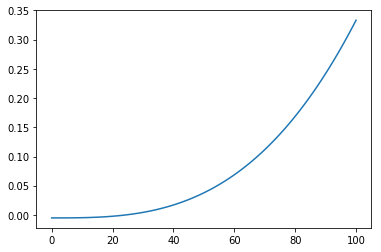

In [497]:
plt.plot(y)

#### test StateSystem

In [483]:
N=10
time_interval=[0,1]
function=partial_f
initial_condition=1
u=np.zeros([1,N])[0]
args_state=(N,time_interval,function)

In [484]:
sy=StateSystem(*args_state)



In [485]:
y=sy.y_calculation(u,initial_condition)

INFO:root:time step0.1
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0


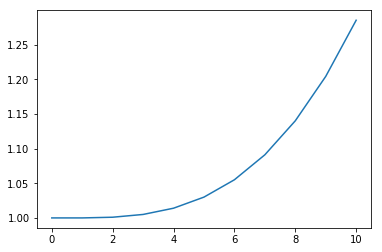

In [486]:
plt.plot(y)

#### test solvers

In [284]:
y=np.zeros([1,101])[0]
delta_t=1/100
x=np.linspace(0,1,101)
y[0]=0
f=partial_f


def explicit_euler_state(y,u,x,h,y1,function):
    logging.info("time step{}".format(h))
    logging.info("initial condition {}".format(y1))
    f=function
    y[0]=y1
    logging.info("Setting initial condition  {}".format(y[0]))
    for i in range(len(x)-1):
        #y[i+1]=y[i]+h*f(y[i],u[i],x[i])
        y[i+1]=y[i]+h*x[i]**2
        
    return y
    
#for i in range(len(x)-1):
  #  y[i+1]=y[i]+delta_t*f(x[i])
y=explicit_euler_state(y,u,x,delta_t,1,f)

INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0


In [226]:
n=1000
y=np.zeros([1,n+1])[0]
delta_t=1/n
x=np.linspace(0,1,n+1)
u=np.linspace(0,1,n+1)
y_state=np.linspace(0,1,n+1)
y[0]=0
f=lambda x:x**2


def explicit_euler_adjoint(y,y_state,u,x,h,y1,function):
    logging.info("time step{}".format(h))
    logging.info("initial condition {}".format(y1))
    logging.info("Old non inverted y: {}..{}".format(y[0],y[len(y)-1]))
    y=np.flip(y)
    logging.info("New inverted y: {}..{}".format(y[0],y[len(y)-1]))
    u=np.flip(u)
    logging.info("Old non inverted x: {}..{}".format(x[0],x[len(x)-1]))
    x=np.flip(x)
    logging.info("New inverted x: {}..{}".format(x[0],x[len(x)-1]))
    f=function
    y[0]=y1
    logging.info("Setting initial condition y_flipped[0] {}".format(y[0]))
    for i in range(len(x)-1):
        #y[i+1]=y[i]-h*f(y[i],u[i],x[i],p[i])
        y[i+1]=y[i]-h*x[i]**2
        
    return np.flip(y)
    
#for i in range(len(x)-1):
  #  y[i+1]=y[i]+delta_t*f(x[i])
y=explicit_euler_adjoint(y,y_state,u,x,delta_t,1.3333,f)

INFO:root:time step0.001
INFO:root:initial condition 1.3333
INFO:root:Old non inverted y: 0.0..0.0
INFO:root:New inverted y: 0.0..0.0
INFO:root:Old non inverted x: 0.0..1.0
INFO:root:New inverted x: 1.0..0.0
INFO:root:Setting initial condition y_flipped[0] 1.3333


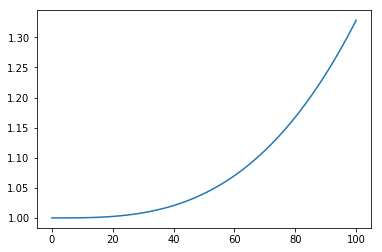

In [233]:
plt.plot(y)

# Functional

## Numerical Integration (composite trapezoidal rule)

In [734]:
def quadrature(y,u,t,function):
    n=len(t)-1
    t0=t[0]
    t1=t[n]
    f=function
    dt=(t1-t0)/(n)
    logging.info("t0 t1 n dt {} {} {} {}".format(t0,t1,n,dt))
    fsum=(dt/2)*(f(y[0],u[0],t[0])+f(y[n],u[n],t[n]))
    fsum=fsum+np.sum(f(y[1:(n)],u[1:(n)],t[1:(n)]))*dt
    return fsum
    
def scalar_product(w,v,t):
    dt=t[1]-t[0]
    n=len(t)-1
    f=w*v
    fsum=(dt/2)*(f[0]+f[n])
    fsum=fsum+np.sum(f[1:n])*dt
    return fsum
    

## J function 

In [705]:
class Jfunctional():
    def __init__(self,g,S,t,y0,u0):
        self.y0=y0
        self.u0=u0
        self.g=g
        self.y=0
        self.u=0
        self.t=t
        self.S=S
        self.yt1=0
        self.value=self.evaluate(self.y0,self.u0)
    def evaluate(self,y,u):
        self.yt1=y[-1]
        j1=quadrature(y,u,self.t,self.g)
        j2=self.S(self.yt1)
        return j1+j2
    def y_update(self,y):
        self.y=y
        self.yt1=y[-1]
    def control_update(self,u):
        self.u=u
    def update(self,y,u,J_value):
        self.control_update(u)
        self.y_update(y)
        self.value=J_value

        

## Functional gradient

In [597]:
def gradient(partial_f,partial_g,y,u,t,p):
    j1f=partial_f(y,u,t)*p
    j2g=partial_g(y,u,t)
    return j1f+j2g

class Gradient():
    def __init__(self,partial_f,partial_g):
        self.partial_f=partial_f
        self.partial_g=partial_g
        self.value=0
    def __call__(self,y,u,t,p):
        self.value=gradient(self.partial_f,self.partial_g,y,u,t,p)
        return self.value
            

# Deepest descent with Armijo search line algorithm

## Abstract Classes

In [1068]:

class SearchLine(ABC):
    def __init__(self):
        self.condition=False
        super().__init__()
    @abstractmethod
    def check_condition(self):
        pass
    @abstractmethod
    def line_search(self,uk,yk,Jk,direction):
        pass
    

    

class SearchDirection(ABC):
    def __init__(self):
        self.u=0
        self.y=0
        self.p=0
        self.t=0
        self.direction=0
        super().__init__()
    @abstractmethod
    def direction_search(self,u,y,p,t):
        pass
    

## Descent Algorithm

In [1106]:
class DescentAlgorithm():
    def __init__(self,u_f,f,g,s,sprime,partial_f_u,partial_g_u,partial_f_y,partial_g_y,N=100,epsilon=0.001,time_interval=[0,1]):
        self.y=0
        self.set_solutions=[]
        self.grad_J=1
        self.direction=0
        self.epsilon=epsilon
        self.convergence=False
        self.f=f
        self.g=g
        self.s=s
        self.sprime=sprime
        self.t=t
        self.partial_f_u=partial_f_u
        self.partial_g_u=partial_g_u
        self.partial_f_y=partial_f_y
        self.partial_g_y=partial_g_y
        self.f_p=lambda y,u,t,p:self.partial_f_y(y,u,t)*p

        logging.info("Creating direction searcher")
        self.direction_searcher=DeepestDescent(self.partial_f_u,partial_g_u)
        logging.info("Creating line searcher")
        self.line_searcher=ArmijoSearchLine()

        
        ###initial conditions
        self.y0=1
        self.p0=1
        ###solver parameters 
        self.N=N
        self.time_interval=time_interval
        self.t0=self.time_interval[0]
        self.t1=self.time_interval[1]
        self.t=np.linspace(self.t0,self.t1,self.N+1)
        #creating u
        self.u=u_f(self.t)
        args_state=(self.N,self.time_interval,self.f)
        
        args_adjoint=(self.partial_f_y,self.partial_g_y,self.N,self.time_interval,self.f_p)
        
        logging.info("Creating solvers")
        self.state_system=StateSystem(*args_state)
        self.adjoint_system=AdjointSystem(*args_adjoint)
        
        
        
        logging.info("Creating Functional and solving first y and p")
        self.y=self.state_system.y_calculation(self.u,self.y0)
        
        logging.info ("creating funciontal with y {}...{} u {} ...{}".format(self.y[0],self.y[-1],self.u[0],self.u[-1]))
        self.J=Jfunctional(self.g,self.s,self.t,self.y,self.u)

        super().__init__()
    def update(self,uk,yk,Jk_value):
        self._last_values=np.array([[self.u],[self.y],[self.J]])
        self.u=np.array(uk)
        self.y=np.array(yk)
        self.J.update(self.y,self.u,Jk_value)
        self._new_values=np.array([[self.u],[self.y],[self.J]])
        logging.info("MAIN Updating u y J {} {} {}".format(self.u,self.y,self.J.value))

    def line_search(self):
        [uk,yk,Jk_value]=self.line_searcher.line_search(self.u,self.y,self.t,self.J,self.direction,self.state_system,self.y0)
        self.update(uk,yk,Jk_value)
    def direction_search(self):
        k=0
        while (not self.check_convergence()):
            logging.info("MAIN direction search time step k {}".format(k))
            self.p0=self.sprime(self.y[-1])
            logging.info("p0 {}".format(self.p0))
            self.p=self.adjoint_system.y_calculation(self.u,self.y,self.p0)
            self.direction=self.direction_searcher.direction_search(self.y,self.u,self.t,self.p)
            self.grad_J=-self.direction
            logging.info(" Direction {}{}....{}".format(self.direction[0],self.direction[1],self.direction[-1]))
            self.line_search()
            k=k+1
            if ((k%5)==0):
                self.set_solutions.append([self.y,self.u,self.p])
    def check_convergence(self):
        logging.info("Checking convergence")
        grad_norm=np.linalg.norm(self.grad_J)
        if grad_norm<self.epsilon:
            self.convergence=True
        logging.info("grad_norm {}".format(grad_norm))
        return self.convergence

## Deepest descent and Armijo Line Search classes

In [1059]:
class DeepestDescent(SearchDirection):
    def __init__(self,partial_f,partial_g):
        self.partial_f=partial_f
        self.partial_g=partial_g
        self.grad_J=Gradient(partial_f,partial_g)
        super().__init__()
    def direction_search(self,y,u,t,p):
        logging.info("Calculating direction Deepest descent")
        self.direction=-self.grad_J(y,u,t,p)
        return self.direction
        
class ArmijoSearchLine(SearchLine):
    def __init__(self,s=0.1,sigma=0.1,beta=0.9):
        self.s=s
        self.sigma=sigma
        self.beta=beta
        self.Jnext_value=0
        self.uknext=0
        self.yknext=0
        self.direction=0
        self.uk=0
        self.yk=0
        self.Jk=0
        self.J=0
        self.grad_J=0
        super().__init__()
    def check_condition(self):
        logging.info("checking condition line search")
        logging.info("scalalr product grad and delta u {}".format(np.dot(self.grad_J,self.uknext-self.uk)))
        from scipy.integrate import simps
        logging.info("integration simpsons scalar product{}".format(simps(self.grad_J*(self.uknext-self.uk), self.t)))
        logging.info("integration with custumo scalar product{}".format(scalar_product(self.grad_J,(self.uknext-self.uk),self.t)))
        cond1=self.J.value+self.sigma*scalar_product(self.grad_J,(self.uknext-self.uk),self.t)
        logging.info("J+ sigma scalar product grad J uknext- uk {}".format(cond1))
        cond=self.Jnext_value<cond1
        self.condition=cond
        if (self.condition):
            logging.info("searchline condition achieved exiting loop")
        return cond
    def calculate_step(self,l,state_system,y0):
        self.uknext=self.uk+(self.beta)**l*self.s*self.direction
        logging.info("norm delta(u) {}".format(np.linalg.norm(self.uknext-self.uk)))
        self.yknext=state_system.y_calculation(self.uknext,y0)
        self.Jnext_value=self.J.evaluate(self.yknext,self.uknext)
        logging.info("calculated step values uknext yknext Jknext J {}..{} {}..{} {} {}".format(self.uknext[0],self.uknext[-1],self.yknext[0],self.yknext[-1],self.Jnext_value,self.J.value))
    def line_search(self,uk,yk,t,J,direction,state_system,y0):
        self.uk=uk
        self.yk=yk
        self.J=J
        self.direction=direction
        self.grad_J=-direction
        self.t=t
        l=1
        while (not self.condition):
            logging.info("calculating step l {}".format(l))
            self.calculate_step(l,state_system,y0)
            self.check_condition()
            l=l+1
            if l>10:
                logging.warning("max iterations reached searchline")
                break
        logging.info("reseting line_search condition")
        self.condition=False
        return [self.uknext,self.yknext,self.Jnext_value]

        

# Test descent algorithm

In [1052]:
f=lambda y,u,t:y+u

s=lambda yp:yp**2
uexacta=lambda t:-((2*np.e**2)/(1+np.e**2))*np.e**(-t)
yexacta=lambda t:((1)/(1+np.e**2))*np.e**(t)+((np.e**2)/(1+np.e**2))*np.e**(-t)
pexacta=lambda t: ((4*np.e**2)/(1+np.e**2))*np.e**(-t)
uf=lambda t:3*np.sin(4*t)+uexacta(t)
partial_f_u=lambda y,u,t:1
partial_g_u=lambda y,u,t:2*u
partial_f_y=lambda y,u,t:1
partial_g_y=lambda y,u,t:0
sprime=lambda y:2*y
g=lambda y,u,t:u**2
time_interval=[0,1]
N=10
t=np.linspace(0,1,N+1)
u=uf(t)

#print(f(y,u,t),s(y),partial_f_u(y,u,t),partial_f_u(y,u,t),partial_g_u(y,u,t),partial_f_y(y,u,t),partial_g_y(y,u,t))

In [1071]:
descent=DescentAlgorithm(uf,f,g,s,sprime,partial_f_u,partial_g_u,partial_f_y,partial_g_y)

INFO:root:Creating direction searcher
INFO:root:Creating line searcher
INFO:root:Creating solvers
INFO:root:Creating Functional and solving first y and p
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:creating funciontal with y 1.0...3.13245679117296 u -1.761594155955765 ...-2.91846175958767
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01


In [1072]:
descent.direction_search()

INFO:root:Checking convergence
INFO:root:grad_norm 1.0
INFO:root:MAIN direction search time step k 0
INFO:root:p0 6.26491358234592
INFO:root:time step0.01
INFO:root:initial condition 6.26491358234592
INFO:root:Setting initial condition y_flipped[0] 6.26491358234592
INFO:root:Calculating direction Deepest descent
INFO:root: Direction -13.422236585748466-13.52945241616953....-0.4279900631705802
INFO:root:calculating step l 1
INFO:root:norm delta(u) 10.823969670208594
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -2.969595448673127..-2.9569808652730223 1.0..1.2660034870189836 3.5673476090992575 11.840070649665478
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1301.759104684395
INFO:root:integration simpsons scalar product-12.936666126216195
INFO:root:integration with custumo scalar product-12.93643822213786
INF

INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -37.565104230741554
INFO:root:integration simpsons scalar product-0.36797959099071115
INFO:root:integration with custumo scalar product-0.36808200863869117
INFO:root:J+ sigma scalar product grad J uknext- uk 2.625426206668845
INFO:root:searchline condition achieved exiting loop
INFO:root:reseting line_search condition
INFO:root:MAIN Updating u y J [-2.89253326 -2.79770004 -2.70325714 -2.60930738 -2.51595331 -2.42329694
 -2.33143967 -2.24048209 -2.15052379 -2.06166323 -1.97399756 -1.88762247
 -1.80263202 -1.71911849 -1.63717224 -1.55688155 -1.47833248 -1.40160871
 -1.32679142 -1.25395916 -1.18318771 -1.11454996 -1.04811577 -0.9839519
 -0.92212185 -0.86268576 -0.80570036 -0.75121883 -0.69929069 -0.64996179
 -0.60327416 -0.55926599 -0.51797155 -0.4794211  -0.44364088 -0.41065306
 -0.38047567 -0.35312262 -0.3286036  -0.30692414 -0.28808554 -0.27208489
 -0.25891509 -0.24856479 -0.24101851 -0.23625654 -0.2342

INFO:root:Checking convergence
INFO:root:grad_norm 12.904118101765254
INFO:root:MAIN direction search time step k 5
INFO:root:p0 1.3008468120316052
INFO:root:time step0.01
INFO:root:initial condition 1.3008468120316052
INFO:root:Setting initial condition y_flipped[0] 1.3008468120316052
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 1.55959983728879251.4551401846103....2.257669942896807
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.9520767682113186
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -2.3987101568594014..-1.5760680826034932 1.0..0.6486465148783591 1.9293769012813535 2.0167717236166505
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -10.071668584085653
INFO:root:integration simpsons scalar product-0.09728622073719118
INFO:root:integration with custumo scalar product-0.0

INFO:root:searchline condition achieved exiting loop
INFO:root:reseting line_search condition
INFO:root:MAIN Updating u y J [-2.18744127 -2.14124258 -2.0952979  -2.04964429 -2.00431866 -1.9593578
 -1.91479825 -1.87067625 -1.82702769 -1.78388807 -1.74129239 -1.69927511
 -1.65787014 -1.6171107  -1.57702932 -1.53765776 -1.49902699 -1.46116708
 -1.4241072  -1.38787555 -1.35249931 -1.3180046  -1.28441642 -1.25175863
 -1.2200539  -1.18932366 -1.15958807 -1.130866   -1.10317497 -1.07653114
 -1.05094926 -1.02644267 -1.00302327 -0.98070147 -0.95948621 -0.93938492
 -0.9204035  -0.90254633 -0.88581626 -0.87021456 -0.85574098 -0.8423937
 -0.83016933 -0.81906297 -0.80906813 -0.80017681 -0.79237947 -0.78566506
 -0.78002103 -0.77543335 -0.77188653 -0.76936363 -0.76784631 -0.76731483
 -0.7677481  -0.76912371 -0.77141794 -0.77460584 -0.77866122 -0.78355671
 -0.78926381 -0.79575294 -0.80299344 -0.81095368 -0.81960106 -0.82890208
 -0.83882239 -0.84932684 -0.86037955 -0.87194394 -0.88398279 -0.89645832
 -

INFO:root:Checking convergence
INFO:root:grad_norm 4.783160065979964
INFO:root:MAIN direction search time step k 10
INFO:root:p0 1.2961209470821784
INFO:root:time step0.01
INFO:root:initial condition 1.2961209470821784
INFO:root:Setting initial condition y_flipped[0] 1.2961209470821784
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.5844279371033840.5456389765221767....0.8393085947998935
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.3529974735578906
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.9924983853477891..-0.9921769974090455 1.0..0.6480587819144575 1.7759533156378484 1.78769167295462
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.3845246259805957
INFO:root:integration simpsons scalar product-0.013368699534040402
INFO:root:integration with custumo scalar product-0

INFO:root:J+ sigma scalar product grad J uknext- uk 1.767519586920525
INFO:root:searchline condition achieved exiting loop
INFO:root:reseting line_search condition
INFO:root:MAIN Updating u y J [-1.91399866 -1.8859499  -1.85810345 -1.83047197 -1.80306808 -1.77590437
 -1.74899336 -1.72234744 -1.69597891 -1.66989992 -1.64412244 -1.61865827
 -1.593519   -1.56871596 -1.54426027 -1.52016275 -1.49643393 -1.47308404
 -1.45012297 -1.42756026 -1.40540508 -1.38366622 -1.36235207 -1.34147059
 -1.32102931 -1.30103533 -1.28149527 -1.26241527 -1.243801   -1.22565762
 -1.20798979 -1.19080164 -1.17409677 -1.15787826 -1.14214863 -1.12690986
 -1.11216336 -1.09790999 -1.08415006 -1.07088329 -1.05810884 -1.04582531
 -1.03403071 -1.0227225  -1.01189758 -1.00155227 -0.99168233 -0.98228297
 -0.97334886 -0.96487413 -0.95685235 -0.94927658 -0.94213937 -0.93543274
 -0.92914824 -0.92327691 -0.91780933 -0.91273563 -0.90804547 -0.9037281
 -0.89977234 -0.89616663 -0.892899   -0.88995713 -0.88732837 -0.8849997
 -0.8

INFO:root:Checking convergence
INFO:root:grad_norm 1.7733098899362705
INFO:root:MAIN direction search time step k 15
INFO:root:p0 1.2961164479888831
INFO:root:time step0.01
INFO:root:initial condition 1.2961164479888831
INFO:root:Setting initial condition y_flipped[0] 1.2961164479888831
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.216676645330738720.20229597351778938....0.3111673268417843
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.13087027012668853
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.841714271116122..-0.7756368279995731 1.0..0.6480582223839874 1.7556459435438685 1.7571584632759687
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.19030030670036013
INFO:root:integration simpsons scalar product-0.0018375008732092954
INFO:root:integration with custumo scalar p

INFO:root:J+ sigma scalar product grad J uknext- uk 1.7545694773532854
INFO:root:searchline condition achieved exiting loop
INFO:root:reseting line_search condition
INFO:root:MAIN Updating u y J [-1.81261113 -1.79129139 -1.77015478 -1.74920493 -1.72844546 -1.70787997
 -1.68751208 -1.66734535 -1.64738333 -1.62762949 -1.6080873  -1.58876013
 -1.56965129 -1.55076403 -1.53210151 -1.51366678 -1.49546281 -1.47749246
 -1.45975847 -1.44226348 -1.42500997 -1.40800031 -1.39123671 -1.37472127
 -1.3584559  -1.34244237 -1.32668228 -1.31117707 -1.295928   -1.28093617
 -1.26620247 -1.25172764 -1.2375122  -1.22355651 -1.2098607  -1.19642473
 -1.18324837 -1.17033116 -1.15767245 -1.14527141 -1.13312697 -1.12123789
 -1.1096027  -1.09821974 -1.08708715 -1.07620285 -1.06556459 -1.05516989
 -1.04501609 -1.03510033 -1.02541958 -1.01597058 -1.00674992 -0.99775399
 -0.988979   -0.98042101 -0.97207589 -0.96393935 -0.95600694 -0.94827405
 -0.94073595 -0.93338774 -0.92622439 -0.91924074 -0.91243151 -0.90579132
 -

INFO:root:Checking convergence
INFO:root:grad_norm 0.6574366323336934
INFO:root:MAIN direction search time step k 20
INFO:root:p0 1.2961164437056805
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437056805
INFO:root:Setting initial condition y_flipped[0] 1.2961164437056805
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.080330671154338780.07499918308546016....0.11536212804720614
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.04851882346646381
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7858124159111657..-0.6953566943521947 1.0..0.6480582218513066 1.7531439613078965 1.7533144487048622
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.026156402561887566
INFO:root:integration simpsons scalar product-0.0002525608774038173
INFO:root:integration with custumo scala

INFO:root:J+ sigma scalar product grad J uknext- uk 1.7530266756284534
INFO:root:searchline condition achieved exiting loop
INFO:root:reseting line_search condition
INFO:root:MAIN Updating u y J [-1.77502272 -1.7561977  -1.7375487  -1.71907599 -1.70077987 -1.68266061
 -1.66471851 -1.64695388 -1.629367   -1.61195815 -1.59472763 -1.57767568
 -1.56080257 -1.54410853 -1.52759376 -1.51125845 -1.49510277 -1.47912683
 -1.46333073 -1.44771454 -1.43227827 -1.41702191 -1.40194539 -1.38704861
 -1.37233142 -1.35779359 -1.34343489 -1.329255   -1.31525355 -1.30143012
 -1.28778423 -1.27431533 -1.26102282 -1.24790604 -1.23496425 -1.22219666
 -1.20960241 -1.19718056 -1.18493013 -1.17285004 -1.16093918 -1.14919633
 -1.13762024 -1.12620957 -1.11496291 -1.10387879 -1.09295568 -1.08219196
 -1.07158598 -1.06113598 -1.05084018 -1.0406967  -1.03070362 -1.02085895
 -1.01116064 -1.0016066  -0.99219466 -0.9829226  -0.97378816 -0.96478901
 -0.95592279 -0.94718708 -0.93857943 -0.93009733 -0.92173825 -0.91349959
 -

INFO:root:Checking convergence
INFO:root:grad_norm 0.24373795398703763
INFO:root:MAIN direction search time step k 25
INFO:root:p0 1.2961164437016037
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437016037
INFO:root:Setting initial condition y_flipped[0] 1.2961164437016037
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0297817804332751730.027805185382543396....0.042769337265422314
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.01798786100424367
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7650873707100148..-0.665593650129625 1.0..0.6480582218507996 1.752907296381214 1.752916861843
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0035951460389776553
INFO:root:integration simpsons scalar product-3.471399539156879e-05
INFO:root:integration with custumo scalar

INFO:root:J+ sigma scalar product grad J uknext- uk 1.7529025472056117
INFO:root:calculating step l 2
INFO:root:norm delta(u) 0.01088553396532786
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7612674285118066..-0.6601078667468772 1.0..0.6480582218507985 1.7529044669863154 1.7529041173875728
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0014628993791395975
INFO:root:integration simpsons scalar product-1.4125457423760348e-05
INFO:root:integration with custumo scalar product-1.4131637649146384e-05
INFO:root:J+ sigma scalar product grad J uknext- uk 1.752902704223808
INFO:root:calculating step l 3
INFO:root:norm delta(u) 0.009796980568795138
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values u

 0.64918937 0.64881734 0.64850475 0.64825169 0.64805822] 1.7529039872469308
INFO:root:Checking convergence
INFO:root:grad_norm 0.13438930821392525
INFO:root:MAIN direction search time step k 28
INFO:root:p0 1.2961164437015973
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015973
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015973
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.018628793240456520.017392413817048702....0.026752636321846657
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.011251581960878686
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7605146459609509..-0.6590268027427558 1.0..0.6480582218508 1.7529054070057866 1.7529039872469308
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.001406645518026335
INFO:root:integration simpsons 

 0.64915524 0.64879125 0.64848704 0.64824267 0.64805822] 1.7529042470552787
INFO:root:Checking convergence
INFO:root:grad_norm 0.12501757734309601
INFO:root:MAIN direction search time step k 29
INFO:root:p0 1.296116443701598
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701598
INFO:root:Setting initial condition y_flipped[0] 1.296116443701598
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.017329701526850540.01617954187318782....0.024887022821593163
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.010466945151523258
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7599820183583725..-0.6582619012076522 1.0..0.6480582218507981 1.752906369974666 1.7529042470552787
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.001217299342277736
INFO:root:integration simpsons sc

INFO:root:Checking convergence
INFO:root:grad_norm 0.11629939057248066
INFO:root:MAIN direction search time step k 30
INFO:root:p0 1.296116443701598
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701598
INFO:root:Setting initial condition y_flipped[0] 1.296116443701598
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.016121202867694250.015051250388812498....0.023151509162359973
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.009737025529914239
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7594865339081185..-0.6575503406073666 1.0..0.6480582218507993 1.7529074874165185 1.7529048183505105
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.001053440735224456
INFO:root:integration simpsons scalar product-1.0171808441548275e-05
INFO:root:integration with custumo sca

INFO:root:Checking convergence
INFO:root:grad_norm 0.10818917255460195
INFO:root:MAIN direction search time step k 31
INFO:root:p0 1.2961164437015982
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015982
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015982
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0149969796940045970.014001641087386663....0.021537022742221135
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00905800735531732
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7590256024069062..-0.6568884011751097 1.0..0.6480582218507984 1.7529087187263206 1.7529056350433296
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0009116388583220263
INFO:root:integration simpsons scalar product-8.802598499048587e-06
INFO:root:integration with custumo 

INFO:root:Checking convergence
INFO:root:grad_norm 0.10064452617019207
INFO:root:MAIN direction search time step k 32
INFO:root:p0 1.2961164437015984
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015984
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015984
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.013951154996819870.01302522701274711....0.020035123643389774
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00842634098030397
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.758596814281061..-0.656272622544589 1.0..0.6480582218507975 1.752910030146413 1.752906641625462
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0007889246924038934
INFO:root:integration simpsons scalar product-7.617695592747295e-06
INFO:root:integration with custumo scalar

 0.64904092 0.64870386 0.6484277  0.64821247 0.64805822] 1.7529077916278673
INFO:root:Checking convergence
INFO:root:grad_norm 0.09362601089226678
INFO:root:MAIN direction search time step k 33
INFO:root:p0 1.2961164437015982
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015982
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015982
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0129782616044442630.012116903845397875....0.01863796051155253
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00783872429455141
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7581979279901865..-0.6556997856605357 1.0..0.6480582218507982 1.7529113937484313 1.7529077916278673
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.000682728872955448
INFO:root:integration simpson

INFO:root:Checking convergence
INFO:root:grad_norm 0.08709693660612654
INFO:root:MAIN direction search time step k 34
INFO:root:p0 1.2961164437016004
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437016004
INFO:root:Setting initial condition y_flipped[0] 1.2961164437016004
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.012073213602150190.01127192321906234....0.017338229511987713
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.007292085462671641
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.757826858309248..-0.6551668959507152 1.0..0.6480582218507978 1.7529127865590055 1.7529090462946866
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0005908278932767456
INFO:root:integration simpsons scalar product-5.7049133865647875e-06
INFO:root:integration with custumo s

INFO:root:Checking convergence
INFO:root:grad_norm 0.08102317180746273
INFO:root:MAIN direction search time step k 35
INFO:root:p0 1.2961164437015964
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015964
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015964
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0112312797449987120.010485867898079704....0.01612913614792455
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.006783566865831822
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7574816654278125..-0.6546711676714473 1.0..0.6480582218507991 1.7529141898094078 1.7529103734432936
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0005112975491467929
INFO:root:integration simpsons scalar product-4.936984637722496e-06
INFO:root:integration with custumo 

 0.64897445 0.64865305 0.6483932  0.6481949  0.64805822] 1.752911746484913
INFO:root:Checking convergence
INFO:root:grad_norm 0.0753729651759091
INFO:root:MAIN direction search time step k 36
INFO:root:p0 1.2961164437015957
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015957
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015957
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0104480587246378320.009754628685722189....0.01500435974148151
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.006310510163213482
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7571605448094636..-0.6542100093448053 1.0..0.6480582218507989 1.7529155882920024 1.752911746484913
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0004424726502224514
INFO:root:integration simpsons

INFO:root:Checking convergence
INFO:root:grad_norm 0.07011677959126086
INFO:root:MAIN direction search time step k 37
INFO:root:p0 1.2961164437015975
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015975
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015975
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0097194561609987850.009074382942940495....0.013958020391607873
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0058704423952243776
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.756861817758373..-0.6537810102113579 1.0..0.6480582218507986 1.752916969808748 1.752913143583636
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00038291215461830976
INFO:root:integration simpsons scalar product-3.697321507021514e-06
INFO:root:integration with custumo 

 0.6489375  0.64862481 0.64837402 0.64818514 0.64805822] 1.7529145469347898
INFO:root:Checking convergence
INFO:root:grad_norm 0.06522713772471561
INFO:root:MAIN direction search time step k 38
INFO:root:p0 1.2961164437015988
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015988
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015988
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.009041663198428030.00844157460505457....0.012984648236200602
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.005461063055811598
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7565839226437205..-0.6533819276276417 1.0..0.6480582218507988 1.752918324698954 1.7529145469347898
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00033136899666166603
INFO:root:integration simpso

INFO:root:Checking convergence
INFO:root:grad_norm 0.0606784783979059
INFO:root:MAIN direction search time step k 39
INFO:root:p0 1.2961164437015946
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015946
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015946
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0084111365944492530.007852895592007858....0.01207915485775568
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.005080232066294242
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.756325406736085..-0.6530106753424771 1.0..0.6480582218508005 1.7529196454352916 1.752915942146155
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0002867639760822728
INFO:root:integration simpsons scalar product-2.7689343454371345e-06
INFO:root:integration with custumo sc

INFO:root:Checking convergence
INFO:root:grad_norm 0.056447022958825546
INFO:root:MAIN direction search time step k 40
INFO:root:p0 1.2961164437015986
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015986
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015986
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00782458019699650.00730526851494151....0.011236806683045941
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.004725958587849659
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7560849186131335..-0.6526653125908481 1.0..0.6480582218507986 1.7529209262785377 1.7529173177077944
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.0002481631619341076
INFO:root:integration simpsons scalar product-2.3962127730943176e-06
INFO:root:integration with custumo 

INFO:root:Checking convergence
INFO:root:grad_norm 0.052510650976106715
INFO:root:MAIN direction search time step k 41
INFO:root:p0 1.2961164437015975
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015975
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015975
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0072789277134939210.006795830588883778....0.010453200237857008
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.004396390614172035
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7558612010948962..-0.6523440339483201 1.0..0.648058221850799 1.7529221629828533 1.7529186645381507
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00021475833813755485
INFO:root:integration simpsons scalar product-2.073662621651905e-06
INFO:root:integration with custum

INFO:root:Checking convergence
INFO:root:grad_norm 0.04884878460191144
INFO:root:MAIN direction search time step k 42
INFO:root:p0 1.2961164437015968
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015968
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015968
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0067713266813465010.006321918667101301....0.009724239127259837
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.004089805289888014
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7556530846717153..-0.652045159892975 1.0..0.6480582218507986 1.7529233525444827 1.7529199755958917
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00018585008121329126
INFO:root:integration simpsons scalar product-1.7945304009389628e-06
INFO:root:integration with custum

INFO:root:Checking convergence
INFO:root:grad_norm 0.04544228099875633
INFO:root:MAIN direction search time step k 43
INFO:root:p0 1.2961164437016002
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437016002
INFO:root:Setting initial condition y_flipped[0] 1.2961164437016002
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0062991235564080480.00588105531923766....0.009046112621245994
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.003804599904129757
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7554594813904938..-0.651767128025511 1.0..0.6480582218507984 1.7529244929878054 1.7529212455482366
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00016083311589449057
INFO:root:integration simpsons scalar product-1.5529716966826552e-06
INFO:root:integration with custumo

 0.64885391 0.64856091 0.64833063 0.64816306 0.64805822] 1.7529224704879178
INFO:root:Checking convergence
INFO:root:grad_norm 0.0422733322681084
INFO:root:MAIN direction search time step k 44
INFO:root:p0 1.2961164437015968
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015968
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015968
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0058598498412854030.005470935880273586....0.008415275733700378
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.003539283512174563
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7552793791672903..-0.6515084849016156 1.0..0.648058221850799 1.752925583183432 1.7529224704879178
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00013918364199500831
INFO:root:integration simpso

INFO:root:Checking convergence
INFO:root:grad_norm 0.03932537235749527
INFO:root:MAIN direction search time step k 45
INFO:root:p0 1.2961164437015986
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015986
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015986
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0054512091809058030.005089416402545677....0.007828430690530963
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0032924691413551057
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7551118364965363..-0.651267878433917 1.0..0.6480582218507992 1.752926622693834 1.7529236476919632
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00012044836718639451
INFO:root:integration simpsons scalar product-1.1630248168220382e-06
INFO:root:integration with custum

INFO:root:Checking convergence
INFO:root:grad_norm 0.03658299045950077
INFO:root:MAIN direction search time step k 46
INFO:root:p0 1.2961164437015975
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015975
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015975
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0050710653581371720.004734502448096478....0.0072825096902109365
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0030628665404981792
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7549559775291999..-0.6510440508237852 1.0..0.6480582218507996 1.752927611642562 1.7529247754163462
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -0.00010423501605448109
INFO:root:integration simpsons scalar product-1.0064720119086464e-06
INFO:root:integration with cust

 0.64882389 0.64853797 0.64831505 0.64815513 0.64805822] 1.7529258527215232
INFO:root:Checking convergence
INFO:root:grad_norm 0.03403185044997982
INFO:root:MAIN direction search time step k 47
INFO:root:p0 1.2961164437015982
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015982
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015982
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.004717431126391780.004404338662444829....0.006774658866451011
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0028492754349830687
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7548109874941848..-0.650835831986044 1.0..0.6480582218507988 1.7529285506037027 1.7529258527215232
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -9.020411671553153e-05
INFO:root:integration simps

 0.64881525 0.64853137 0.64831056 0.64815285 0.64805822] 1.7529268793244017
INFO:root:Checking convergence
INFO:root:grad_norm 0.03165861594425586
INFO:root:MAIN direction search time step k 48
INFO:root:p0 1.2961164437015964
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015964
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015964
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0043884578211086380.00409719907554873....0.006302223369299975
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.002650579252166115
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7546761084390174..-0.6506421334322112 1.0..0.6480582218507989 1.7529294405086557 1.7529268793244017
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -7.806189302237231e-05
INFO:root:integration simps

 0.64880721 0.64852522 0.64830639 0.64815072 0.64805822] 1.7529278554730292
INFO:root:Checking convergence
INFO:root:grad_norm 0.02945088057962361
INFO:root:MAIN direction search time step k 49
INFO:root:p0 1.296116443701598
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701598
INFO:root:Setting initial condition y_flipped[0] 1.296116443701598
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0040824256956049080.0038114780790587943....0.005862733486584615
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0024657392843646184
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.754550635267562..-0.6504619425802987 1.0..0.6480582218507982 1.752930282567727 1.7529278554730292
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -6.755411353843471e-05
INFO:root:integration simpson

INFO:root:Checking convergence
INFO:root:grad_norm 0.027397103159607705
INFO:root:MAIN direction search time step k 50
INFO:root:p0 1.2961164437015973
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015973
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015973
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00379773493093171770.0035456820328430005....0.005453891733220306
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0022937892588917375
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7544339120540455..-0.650294317461419 1.0..0.6480582218507996 1.7529310782043979 1.7529287818406998
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -5.846076849118846e-05
INFO:root:integration simpsons scalar product-5.64485232585364e-07
INFO:root:integration with custu

INFO:root:Checking convergence
INFO:root:grad_norm 0.025486547321018602
INFO:root:MAIN direction search time step k 51
INFO:root:p0 1.2961164437015986
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015986
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015986
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0035328972726027530.003298421456779721....0.005073560840816338
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0021338302867498194
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.754325328614132..-0.650138381795534 1.0..0.6480582218507983 1.75293182900039 1.752929659436747
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -5.059146325167473e-05
INFO:root:integration simpsons scalar product-4.885008294880807e-07
INFO:root:integration with custumo sc

INFO:root:Checking convergence
INFO:root:grad_norm 0.02370922540833086
INFO:root:MAIN direction search time step k 52
INFO:root:p0 1.2961164437015984
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015984
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015984
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0032865282505936120.0030684037671111497....0.0047197525848710065
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0019850261635854832
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7542243173151084..-0.6499933204105963 1.0..0.6480582218507991 1.752932536649989 1.7529304895315407
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -4.378143189020888e-05
INFO:root:integration simpsons scalar product-4.227445584672892e-07
INFO:root:integration with custu

 0.64878028 0.64850464 0.64829241 0.64814361 0.64805822] 1.7529312735936817
INFO:root:Checking convergence
INFO:root:grad_norm 0.02205584626206035
INFO:root:MAIN direction search time step k 53
INFO:root:p0 1.2961164437015993
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015993
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015993
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00305733994184054230.0028544265192875784....0.004390617391079932
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0018465989983300524
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.75413035010852..-0.6498583749811424 1.0..0.6480582218507988 1.752933202922173 1.7529312735936817
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -3.788808734037217e-05
INFO:root:integration simp

 0.64877468 0.64850035 0.6482895  0.64814213 0.64805822] 1.752932013237562
INFO:root:Checking convergence
INFO:root:grad_norm 0.02051776664811135
INFO:root:MAIN direction search time step k 54
INFO:root:p0 1.2961164437015977
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015977
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015977
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0028441342374883050.0026553711220658194....0.004084434666481895
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0017178251466846725
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.754042935769734..-0.6497328400640564 1.0..0.6480582218507988 1.7529338296294608 1.752932013237562
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -3.278803593980127e-05
INFO:root:integration simps

INFO:root:Checking convergence
INFO:root:grad_norm 0.019086946074273477
INFO:root:MAIN direction search time step k 55
INFO:root:p0 1.2961164437015973
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015973
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015973
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00264579657961627750.00247019698992057....0.003799603804842455
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0015980314281825118
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7539616173300063..-0.649616059410784 1.0..0.6480582218507986 1.7529344186024025 1.7529327101797938
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.8374493838434247e-05
INFO:root:integration simpsons scalar product-2.7397831344441875e-07
INFO:root:integration with cust

 0.64876462 0.64849267 0.64828428 0.64813947 0.64805822] 1.7529333662031632
INFO:root:Checking convergence
INFO:root:grad_norm 0.01775590475758377
INFO:root:MAIN direction search time step k 56
INFO:root:p0 1.2961164437015966
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015966
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015966
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00246129013477691670.002297936103284659....0.0035346358193091287
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0014865916070606047
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7538859696876214..-0.649507422536715 1.0..0.6480582218507992 1.7529349716688825 1.7529333662031632
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.4555051179811062e-05
INFO:root:integration s

INFO:root:Checking convergence
INFO:root:grad_norm 0.01651768452289534
INFO:root:MAIN direction search time step k 57
INFO:root:p0 1.2961164437016002
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437016002
INFO:root:Setting initial condition y_flipped[0] 1.2961164437016002
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00228965037380435280.0021376879480889954....0.003288145558545841
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0013829231185372862
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7538155973856262..-0.6494063615298039 1.0..0.6480582218507985 1.752935490637479 1.7529339831269977
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.1249737242055076e-05
INFO:root:integration simpsons scalar product-2.0518311987753614e-07
INFO:root:integration with cus

INFO:root:Checking convergence
INFO:root:grad_norm 0.015365812428192585
INFO:root:MAIN direction search time step k 58
INFO:root:p0 1.2961164437015962
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015962
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015962
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0021299800296699090.0019886148082650656....0.003058844465714694
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0012864840233876285
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753750132544527..-0.6493123480817411 1.0..0.6480582218507998 1.7529359772842539 1.7529345627829531
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.838934602701751e-05
INFO:root:integration simpsons scalar product-1.7756376689982042e-07
INFO:root:integration with cust

INFO:root:Checking convergence
INFO:root:grad_norm 0.014294266926528822
INFO:root:MAIN direction search time step k 59
INFO:root:p0 1.2961164437016
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437016
INFO:root:Setting initial condition y_flipped[0] 1.2961164437016
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0019814444068244620.001849937386396494....0.0028455338423480914
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0011967701748896592
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7536892329391642..-0.6492248907261627 1.0..0.6480582218507981 1.7529364333424158 1.7529351069954382
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.5913987238949307e-05
INFO:root:integration simpsons scalar product-1.53662208345649e-07
INFO:root:integration with custumo scala

INFO:root:Checking convergence
INFO:root:grad_norm 0.013297446387662995
INFO:root:MAIN direction search time step k 60
INFO:root:p0 1.2961164437015988
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015988
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015988
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00184326701784343070.0017209307299643761....0.0026470985820687964
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0011133125833419492
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753632580209681..-0.6491435322694477 1.0..0.6480582218507985 1.7529368604944118 1.7529356175658757
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.377183231363937e-05
INFO:root:integration simpsons scalar product-1.3297799819144939e-07
INFO:root:integration with cu

 0.64874501 0.64847767 0.6482741  0.64813429 0.64805822] 1.7529360962602936
INFO:root:Checking convergence
INFO:root:grad_norm 0.012370139814910733
INFO:root:MAIN direction search time step k 61
INFO:root:p0 1.2961164437015977
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015977
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015977
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00171472552415208310.001600920441478415....0.0024625013411925245
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0010356749643613645
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7535798781972662..-0.6490678474006878 1.0..0.6480582218507981 1.752937260366022 1.7529360962602936
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.1918029242277575e-05
INFO:root:integration 

INFO:root:Checking convergence
INFO:root:grad_norm 0.011507499604015892
INFO:root:MAIN direction search time step k 62
INFO:root:p0 1.2961164437015984
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015984
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015984
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00159514795995763240.0014892791530245475....0.0022907771159135226
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0009634514581564422
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7535308513959476..-0.6489974404683237 1.0..0.6480582218507992 1.7529376345221552 1.7529365447996397
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.0313763469153596e-05
INFO:root:integration simpsons scalar product-9.958759217463148e-08
INFO:root:integration with c

INFO:root:Checking convergence
INFO:root:grad_norm 0.010705016201738811
INFO:root:MAIN direction search time step k 63
INFO:root:p0 1.2961164437015968
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015968
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015968
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00148390921948005070.001385423246638151....0.002131028197636331
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0008962645078482229
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.75348524351235..-0.6489319434118294 1.0..0.6480582218507989 1.7529379844640154 1.7529369648524142
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -8.925445200315127e-06
INFO:root:integration simpsons scalar product-8.618227470935772e-08
INFO:root:integration with custum

INFO:root:Checking convergence
INFO:root:grad_norm 0.00995849453164623
INFO:root:MAIN direction search time step k 64
INFO:root:p0 1.296116443701597
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701597
INFO:root:Setting initial condition y_flipped[0] 1.296116443701597
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00138042778910030250.0012888098033347894....0.00198241948008393
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0008337628857454591
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7534428161258944..-0.6488710138376329 1.0..0.6480582218507996 1.7529383116274417 1.752937358029238
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -7.724006107183826e-06
INFO:root:integration simpsons scalar product-7.458142437114011e-08
INFO:root:integration with custumo s

INFO:root:Checking convergence
INFO:root:grad_norm 0.009264032063837753
INFO:root:MAIN direction search time step k 65
INFO:root:p0 1.2961164437015977
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015977
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015977
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00128416270746400940.0011989337649711551....0.0018441740936954165
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.000775619857262502
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753403347442424..-0.648814333229214 1.0..0.6480582218507983 1.7529386173821617 1.7529377258790144
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -6.68429069977644e-06
INFO:root:integration simpsons scalar product-6.454214488987266e-08
INFO:root:integration with custum

INFO:root:Checking convergence
INFO:root:grad_norm 0.00861799841402745
INFO:root:MAIN direction search time step k 66
INFO:root:p0 1.2961164437015993
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015993
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015993
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00119461073752624710.0011153252939775093....0.0017155693444412812
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0007215314728740744
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753366631134751..-0.6487616052820205 1.0..0.6480582218507984 1.7529389030318356 1.752938069886421
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -5.7845296260873765e-06
INFO:root:integration simpsons scalar product-5.5854235851711624e-08
INFO:root:integration with cus

 0.64872915 0.64846556 0.64826588 0.6481301  0.64805822] 1.7529383914704932
INFO:root:Checking convergence
INFO:root:grad_norm 0.008017016365268
INFO:root:MAIN direction search time step k 67
INFO:root:p0 1.296116443701597
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701597
INFO:root:Setting initial condition y_flipped[0] 1.296116443701597
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00111130373583323560.0010375473172401506....0.0015959329358627983
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0006712149791852482
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753332475264055..-0.6487125543545023 1.0..0.6480582218507996 1.7529391698146883 1.7529383914704932
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -5.0058838698073355e-06
INFO:root:integration simps

INFO:root:Checking convergence
INFO:root:grad_norm 0.0074579442131695395
INFO:root:MAIN direction search time step k 68
INFO:root:p0 1.296116443701597
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701597
INFO:root:Setting initial condition y_flipped[0] 1.296116443701597
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00103380620521553720.000965193241218909....0.0014846394545466879
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.000624407340802424
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7533007012765016..-0.6486669240271626 1.0..0.6480582218507991 1.7529394189046443 1.75293869198411
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -4.332050302755257e-06
INFO:root:integration simpsons scalar product-4.182939235721423e-08
INFO:root:integration with custumo 

INFO:root:Checking convergence
INFO:root:grad_norm 0.006937859342249487
INFO:root:MAIN direction search time step k 69
INFO:root:p0 1.2961164437015964
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015964
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015964
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00096171301821579290.0008978848264709072....0.0013811071007228115
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0005808638652869198
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7532711430698313..-0.6486244757620946 1.0..0.6480582218507991 1.7529396514128508 1.7529389727141798
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -3.7489203332896897e-06
INFO:root:integration simpsons scalar product-3.6198808549701186e-08
INFO:root:integration with 

 0.64872346 0.6484612  0.64826292 0.6481286  0.64805822] 1.7529392348824293
INFO:root:Checking convergence
INFO:root:grad_norm 0.006454042947632656
INFO:root:MAIN direction search time step k 70
INFO:root:p0 1.2961164437015955
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015955
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015955
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00089464729921484580.0008352702103362475....0.0012847946468255156
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0005403569239953621
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.75324364612504..-0.6485849876559963 1.0..0.6480582218507994 1.7529398683894803 1.7529392348824293
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -3.2442845034412824e-06
INFO:root:integration 

INFO:root:Checking convergence
INFO:root:grad_norm 0.0060039658221704
INFO:root:MAIN direction search time step k 71
INFO:root:p0 1.296116443701596
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701596
INFO:root:Setting initial condition y_flipped[0] 1.296116443701596
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00083225845426859730.0007770220675356043....0.001195198608164194
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0005026747621240924
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7532180666986121..-0.6485482532801453 1.0..0.6480582218507995 1.7529400708257632 1.7529394796466422
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.8075768497389607e-06
INFO:root:integration simpsons scalar product-2.7109388260349327e-08
INFO:root:integration with custum

INFO:root:Checking convergence
INFO:root:grad_norm 0.005585275134711997
INFO:root:MAIN direction search time step k 72
INFO:root:p0 1.2961164437015988
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015988
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015988
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0007742203383434010.000722835899042984....0.0011118506109004667
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0004676203917367748
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753194271071086..-0.6485140806012686 1.0..0.6480582218507984 1.7529402596561705 1.752939708102256
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.42965367520083e-06
INFO:root:integration simpsons scalar product-2.3460239325361273e-08
INFO:root:integration with custum

INFO:root:Checking convergence
INFO:root:grad_norm 0.0051957821304090815
INFO:root:MAIN direction search time step k 73
INFO:root:p0 1.2961164437016
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437016
INFO:root:Setting initial condition y_flipped[0] 1.2961164437016
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00072022955036787910.0006724284402954694....0.001034314943572756
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0004350105619868189
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7531721348480171..-0.6484822909776649 1.0..0.6480582218507993 1.7529404357607132 1.7529399212842303
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.1026021004454364e-06
INFO:root:integration simpsons scalar product-2.030229616094889e-08
INFO:root:integration with custumo sc

INFO:root:Checking convergence
INFO:root:grad_norm 0.0048334506887424645
INFO:root:MAIN direction search time step k 74
INFO:root:p0 1.2961164437015988
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015988
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015988
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.0006700038471429970.0006255361803693127....0.0009621862793545155
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00040467480115067336
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7531515423096937..-0.6484527182253348 1.0..0.6480582218507989 1.7529405999672907 1.7529401201691273
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.8195743854040473e-06
INFO:root:integration simpsons scalar product-1.75694383885177e-08
INFO:root:integration with c

INFO:root:Checking convergence
INFO:root:grad_norm 0.0044963866794526745
INFO:root:MAIN direction search time step k 75
INFO:root:p0 1.2961164437015997
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015997
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015997
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00062328066788497340.0005819139844485122....0.0008950875571593908
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0003764545254682234
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7531323858061987..-0.6484252077492352 1.0..0.6480582218507985 1.7529407530540886 1.7529403056773316
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.5746445527273417e-06
INFO:root:integration simpsons scalar product-1.5204445981921003e-08
INFO:root:integration with

INFO:root:Checking convergence
INFO:root:grad_norm 0.004182828060756724
INFO:root:MAIN direction search time step k 76
INFO:root:p0 1.2961164437015968
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015968
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015968
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00057981576168586460.0005413338123800848....0.0008326680105257278
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0003502022101265565
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7531145651946545..-0.648399615735114 1.0..0.6480582218507992 1.7529408957519599 1.7529404786753533
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.362684310861151e-06
INFO:root:integration simpsons scalar product-1.3157801205997326e-08
INFO:root:integration with cu

INFO:root:Checking convergence
INFO:root:grad_norm 0.003891135668072175
INFO:root:MAIN direction search time step k 77
INFO:root:p0 1.296116443701596
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701596
INFO:root:Setting initial condition y_flipped[0] 1.296116443701596
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00053938191062208320.0005035835265276845....0.0007746013339202662
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0003257806180574247
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753097987315717..-0.6483758083977053 1.0..0.6480582218507989 1.752941028746791 1.7529406399782106
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.1792556789093039e-06
INFO:root:integration simpsons scalar product-1.1386651824239402e-08
INFO:root:integration with custu

 0.64871314 0.64845332 0.64825756 0.64812587 0.64805822] 1.7529407903518075
INFO:root:Checking convergence
INFO:root:grad_norm 0.003619784645081123
INFO:root:MAIN direction search time step k 78
INFO:root:p0 1.2961164437015982
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015982
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015982
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00050176774197474570.0004684657828253336....0.0007205839769559574
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00030306208251332294
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7530825655065738..-0.6483536612813511 1.0..0.6480582218507998 1.7529411526818386 1.7529407903518075
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.020518065081217e-06
INFO:root:integratio

INFO:root:Checking convergence
INFO:root:grad_norm 0.0033673564723701583
INFO:root:MAIN direction search time step k 79
INFO:root:p0 1.2961164437015984
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015984
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015984
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00046677662326066740.00043579699914486625....0.0006703335575464209
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.000281927839676414
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753068219147902..-0.6483330586093933 1.0..0.6480582218507989 1.7529412681599879 1.75294093051532
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -8.831478531624988e-07
INFO:root:integration simpsons scalar product-8.52749517610338e-09
INFO:root:integration with custu

INFO:root:Checking convergence
INFO:root:grad_norm 0.0031325315519607506
INFO:root:MAIN direction search time step k 80
INFO:root:p0 1.2961164437015993
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015993
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015993
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000434225634284857160.00040540639557162805....0.0006235873857072249
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00026226740780453266
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7530548732424223..-0.6483138926789396 1.0..0.6480582218507991 1.7529413757459793 1.7529410611435614
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -7.642688132945732e-07
INFO:root:integration simpsons scalar product-7.3796234631357105e-09
INFO:root:integration wi

 0.64871057 0.64845135 0.64825623 0.64812519 0.64805822] 1.7529411828692911
INFO:root:Checking convergence
INFO:root:grad_norm 0.0029140823089393595
INFO:root:MAIN direction search time step k 81
INFO:root:p0 1.296116443701598
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701598
INFO:root:Setting initial condition y_flipped[0] 1.296116443701598
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00040394461092541080.00037713510165193753....0.0005801010903256909
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00024397800967624833
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7530424580228432..-0.6482960632978325 1.0..0.6480582218507979 1.7529414759685311 1.7529411828692911
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -6.613918800619264e-07
INFO:root:integration

 0.64870983 0.64845078 0.64825584 0.64812499 0.64805822] 1.7529412962854773
INFO:root:Checking convergence
INFO:root:grad_norm 0.002710866774180075
INFO:root:MAIN direction search time step k 82
INFO:root:p0 1.2961164437015995
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015995
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015995
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00037577525555709810.0003508353258583341....0.0005396473416692249
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.0002269640353096392
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753030908587144..-0.6482794772608841 1.0..0.6480582218507984 1.7529415693224126 1.7529412962854773
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -5.723630369336319e-07
INFO:root:integration 

INFO:root:Checking convergence
INFO:root:grad_norm 0.0025218226145511404
INFO:root:MAIN direction search time step k 83
INFO:root:p0 1.296116443701599
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701599
INFO:root:Setting initial condition y_flipped[0] 1.296116443701599
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000349570309570168550.00032636958302845187....0.0005020146630101419
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00021113654215150306
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.753020164559289..-0.6482640478626337 1.0..0.6480582218507984 1.7529416562704028 1.752941401947484
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -4.953182159077609e-07
INFO:root:integration simpsons scalar product-4.782691461756789e-09
INFO:root:integration with cus

INFO:root:Checking convergence
INFO:root:grad_norm 0.0023459615794614113
INFO:root:MAIN direction search time step k 84
INFO:root:p0 1.2961164437015968
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015968
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015968
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000325192783525274360.0003036099756115185....0.00046700632509111273
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00019641279011853226
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7530101697736085..-0.6482496944440858 1.0..0.6480582218507994 1.7529417372451948 1.752941500375193
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -4.2864426802385555e-07
INFO:root:integration simpsons scalar product-4.1389014475282726e-09
INFO:root:integration wi

 0.64870791 0.64844931 0.64825485 0.64812449 0.64805822] 1.7529415920550415
INFO:root:Checking convergence
INFO:root:grad_norm 0.0021823643346503808
INFO:root:MAIN direction search time step k 85
INFO:root:p0 1.2961164437015966
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015966
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015966
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00030251524102764550.00028243752507295383....0.0004344393177013739
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00018271580906371163
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7530008719811843..-0.6482363419710558 1.0..0.6480582218507993 1.752941812651194 1.7529415920550415
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -3.709451875755682e-07
INFO:root:integrati

INFO:root:Checking convergence
INFO:root:grad_norm 0.002030175656263123
INFO:root:MAIN direction search time step k 86
INFO:root:p0 1.296116443701598
INFO:root:time step0.01
INFO:root:initial condition 1.296116443701598
INFO:root:Setting initial condition y_flipped[0] 1.296116443701598
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000281419132556415260.00026274154993766174....0.00040414339297711876
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00016997399640644777
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.752992222576712..-0.6482239206419196 1.0..0.6480582218508002 1.7529418828662413 1.752941677441973
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -3.2101288282646843e-07
INFO:root:integration simpsons scalar product-3.099634789312392e-09
INFO:root:integration with cu

INFO:root:Checking convergence
INFO:root:grad_norm 0.0018885999600718405
INFO:root:MAIN direction search time step k 87
INFO:root:p0 1.2961164437015977
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015977
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015977
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000261794175725693630.00024441908718131344....0.00037596017540941773
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00015812074282168118
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7529841763444114..-0.6482123655227168 1.0..0.6480582218507998 1.7529419482432371 1.7529417569613082
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.7780188122745456e-07
INFO:root:integration simpsons scalar product-2.682398189154831e-09
INFO:root:integration w

INFO:root:Checking convergence
INFO:root:grad_norm 0.0017568971424624688
INFO:root:MAIN direction search time step k 88
INFO:root:p0 1.2961164437015986
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015986
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015986
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.00024353777875951720.00022737435396935624....0.00034974233390827614
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00014709408403057006
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7529766912216564..-0.6482016162077017 1.0..0.6480582218507982 1.7529420091116994 1.752941831010527
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.404074395198888e-07
INFO:root:integration simpsons scalar product-2.3213251025454854e-09
INFO:root:integration wit

INFO:root:Checking convergence
INFO:root:grad_norm 0.0016343787114505963
INFO:root:MAIN direction search time step k 89
INFO:root:p0 1.2961164437015977
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015977
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015977
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000226554504201281760.000211518246959308....0.00032535281162426877
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00013683637687717082
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7529697280790864..-0.6481916165035648 1.0..0.6480582218507978 1.7529420657792278 1.752941899960967
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -2.0804660040969175e-07
INFO:root:integration simpsons scalar product-2.008855453868418e-09
INFO:root:integration with

INFO:root:Checking convergence
INFO:root:grad_norm 0.0015204041875242116
INFO:root:MAIN direction search time step k 90
INFO:root:p0 1.2961164437015964
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015964
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015964
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000210755569978626770.00019676787648048588....0.0003026641094576732
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00012729399798950744
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7529632505160542..-0.6481823141356758 1.0..0.6480582218507988 1.752942118532887 1.7529419641594317
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.8004179915726316e-07
INFO:root:integration simpsons scalar product-1.7384468164777184e-09
INFO:root:integration wi

INFO:root:Checking convergence
INFO:root:grad_norm 0.0014143777554390554
INFO:root:MAIN direction search time step k 91
INFO:root:p0 1.2961164437015982
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015982
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015982
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000196058385299568980.00018304613323127938....0.0002815576195438485
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00011841706345869987
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.752957224670337..-0.6481736604748121 1.0..0.648058221850799 1.7529421676405121 1.752942023929724
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.558066768687756e-07
INFO:root:integration simpsons scalar product-1.5044374287335778e-09
INFO:root:integration with 

INFO:root:Checking convergence
INFO:root:grad_norm 0.0013157451495418653
INFO:root:MAIN direction search time step k 92
INFO:root:p0 1.2961164437015982
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015982
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015982
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000182386118908528520.00017028128519092078....0.0002619230052276489
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00011015916806513578
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7529516190411167..-0.6481656102829424 1.0..0.6480582218507986 1.752942213351949 1.7529420795740802
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.3483380343118691e-07
INFO:root:integration simpsons scalar product-1.301927649167192e-09
INFO:root:integration wit

INFO:root:Checking convergence
INFO:root:grad_norm 0.0012239907562796892
INFO:root:MAIN direction search time step k 93
INFO:root:p0 1.2961164437015997
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015997
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015997
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000169667297417852580.00015840660260790784....0.00024365762424838344
INFO:root:calculating step l 1
INFO:root:norm delta(u) 0.00010247714268841722
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.752946404324307..-0.6481581214767417 1.0..0.6480582218507985 1.752942255900217 1.7529421313745484
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.1668405303973747e-07
INFO:root:integration simpsons scalar product-1.1266773687575618e-09
INFO:root:integration wi

INFO:root:Checking convergence
INFO:root:grad_norm 0.0011386349187595566
INFO:root:MAIN direction search time step k 94
INFO:root:p0 1.2961164437015984
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015984
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015984
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000157835431699560050.00014736000918968983....0.00022666599218146288
INFO:root:calculating step l 1
INFO:root:norm delta(u) 9.533082863678612e-05
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.7529415532593617..-0.6481511549075936 1.0..0.6480582218507992 1.752942295502596 1.7529421795942681
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -1.0097740987301028e-07
INFO:root:integration simpsons scalar product-9.750172323969255e-10
INFO:root:integration wit

INFO:root:Checking convergence
INFO:root:grad_norm 0.001059231429296999
INFO:root:MAIN direction search time step k 95
INFO:root:p0 1.2961164437015977
INFO:root:time step0.01
INFO:root:initial condition 1.2961164437015977
INFO:root:Setting initial condition y_flipped[0] 1.2961164437015977
INFO:root:Calculating direction Deepest descent
INFO:root: Direction 0.000146828669278065150.00013708375756449342....0.00021085928326658454
INFO:root:calculating step l 1
INFO:root:norm delta(u) 8.868286771232039e-05
INFO:root:time step0.01
INFO:root:initial condition 1
INFO:root:Setting initial condition  1.0
INFO:root:t0 t1 n dt 0.0 1.0 100 0.01
INFO:root:calculated step values uknext yknext Jknext J -1.752937040486768..-0.6481446741569382 1.0..0.6480582218507989 1.752942332361659 1.752942224478693
INFO:root:checking condition line search
INFO:root:scalalr product grad and delta u -8.738501139646384e-08
INFO:root:integration simpsons scalar product-8.437718106642964e-10
INFO:root:integration with cu

INFO:root:Checking convergence
INFO:root:grad_norm 0.0009853651968036636


In [1073]:
descent.set_solutions

[[array([1.        , 0.98460926, 0.96976109, 0.95545772, 0.9417007 ,
         0.92849092, 0.9158286 , 0.90371326, 0.89214379, 0.88111837,
         0.87063452, 0.86068908, 0.85127823, 0.84239747, 0.83404165,
         0.82620497, 0.81888097, 0.81206256, 0.80574203, 0.79991104,
         0.79456064, 0.78968129, 0.78526288, 0.78129472, 0.77776558,
         0.77466368, 0.77197675, 0.76969198, 0.76779611, 0.76627542,
         0.76511573, 0.76430245, 0.76382059, 0.76365479, 0.76378933,
         0.76420816, 0.76489493, 0.765833  , 0.76700549, 0.76839528,
         0.76998505, 0.77175729, 0.77369435, 0.77577845, 0.77799172,
         0.78031621, 0.78273394, 0.78522689, 0.78777708, 0.79036654,
         0.7929774 , 0.79559185, 0.79819222, 0.80076098, 0.80328079,
         0.80573448, 0.80810513, 0.81037606, 0.8125309 , 0.81455353,
         0.81642819, 0.81813948, 0.81967236, 0.82101217, 0.82214471,
         0.82305618, 0.82373328, 0.82416318, 0.82433352, 0.82423251,
         0.82384887, 0.82317187, 0

# plots 

In [1119]:
%matplotlib inline

## Control

Text(0.5, 1.0, 'Control beta 0.9 sigma 0.1 s 0.1')

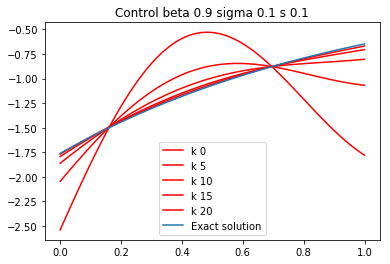

In [1120]:
plt.figure(1)
for s,i in enumerate(descent.set_solutions[0:5]):
    plt.plot(descent.t,i[1],color="red",label="k {}".format(5*s))
plt.plot(descent.t,uexacta(descent.t),label="Exact solution")
plt.legend()
plt.title("Control beta {} sigma {} s {}".format(0.9,0.1,0.1))

## State

Text(0.5, 1.0, 'State beta 0.9 sigma 0.1 s 0.1')

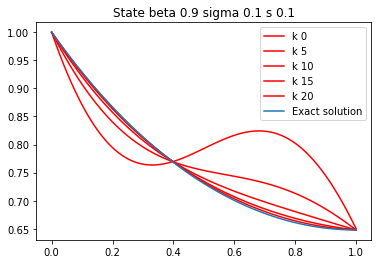

In [1121]:
plt.figure(2)
for s,i in enumerate(descent.set_solutions[0:5]):
    plt.plot(descent.t,i[0],color="red",label="k {}".format(5*s))
plt.plot(descent.t,yexacta(descent.t),label="Exact solution")
plt.legend()
plt.title("State beta {} sigma {} s {}".format(0.9,0.1,0.1))

## Adjoint

Text(0.5, 1.0, 'Adjoint beta 0.9 sigma 0.1 s 0.1')

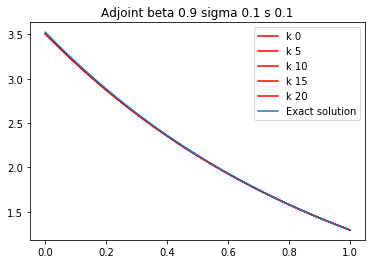

In [1122]:
plt.figure(3)
for s,i in enumerate(descent.set_solutions[0:5]):
    plt.plot(descent.t,i[2],color="red",label="k {}".format(5*s))
plt.plot(descent.t,pexacta(descent.t),label="Exact solution")
plt.legend()
plt.title("Adjoint beta {} sigma {} s {}".format(0.9,0.1,0.1))